In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.19 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 5)

In [4]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1
...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1


In [5]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(45, 5)

In [6]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    # random_state=12
)

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [7]:
data_train.shape, data_test.shape

((36, 5), (9, 5))

In [8]:
transform = NiftiToTensorTransform(target_shape = (300, 300), rpn_mode=True) # Hanggang dito lang kaya ng GPU mem ko

In [9]:
train_set = VALDODataset(
    cases=data_train.mri,
    masks=data_train.masks,
    target=data_train.target,
    transform=transform,
    normalization=z_score_normalization,
)

val_set = VALDODataset(
    cases=data_test.mri,
    masks=data_test.masks,
    target=data_test.target,
    transform=transform,
    normalization=z_score_normalization,
)

batch_size = 20

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=collatev2,
)

val_loader = DataLoader(
    val_set,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=collatev2,
)

### Config for fitter

In [10]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=2500,
        output_dim=4,
        image_size=300
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 20,
    # 'loss': nn.SmoothL1Loss(),
    'loss': nn.MSELoss(),
    'lr': 0.0001
}

1369


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load Pretrained Embedder

### Load RPN Weights

### Sample trial

### Fitter

In [11]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)
                Y.append(y)
                T.append(masks[target])
                self.log(memcheck())
                # memcheck()
                # del x, y, masks, slices
                # torch.cuda.empty_cache()
                # memcheck()
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                self.log(f'Progress:\t{counter}/{len(dataset)}')
                self.log(f'Current error:\t{losses}')
            
            loss_history.append(losses.detach().cpu().numpy())
            
            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
        
        return loss_history
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        return loss_history
                

In [12]:
fitter = RPNFitter(config, logger=logger)

### Training

In [13]:
thist, vhist = fitter.fit(train_loader, val_loader)

INFO:andy:EPOCH 0 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1

In [14]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

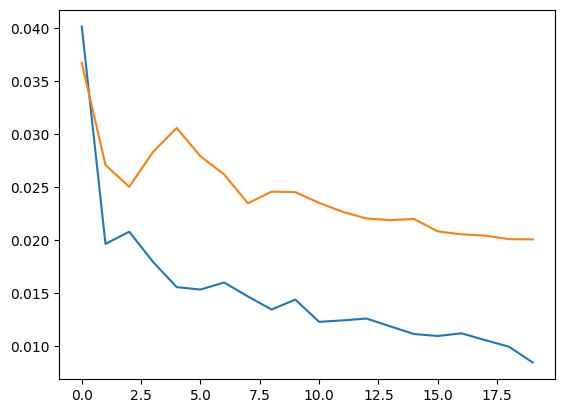

In [15]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1))
sns.lineplot(vh.mean(1))

### Save the weights

# Summary

Applied Sigmoid activation function to the fully connected layer of the RPN model. Lead to even lower scores

Using all cohorts means we can only use about 2-3 samples per batch

Applied train and test split as well

### Next tasks
- use half precision
- train with all cohorts

# Trial

In [16]:
model = fitter.model

In [17]:
sample = next(enumerate(train_loader))

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

In [18]:
slices, masks, target, case = sample[1][2]

In [19]:
x = slices.squeeze(1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [20]:
y = model(x, target)

In [21]:
fitter.loss(y, T[target])

tensor(8790.3916, device='cuda:0', grad_fn=<MseLossBackward0>)

In [22]:
masks[target]

tensor([[[ 63.2812, 105.4688,  77.3438, 119.5312]]], dtype=torch.float64)

In [23]:
y

tensor([[0.2690, 0.3597, 0.2908, 0.3425]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [24]:
bbox = masks[target].squeeze().cpu().long()

In [25]:
y = (y*300).squeeze().detach().cpu().long()

In [26]:
bbox, y

(tensor([ 63, 105,  77, 119]), tensor([ 80, 107,  87, 102]))

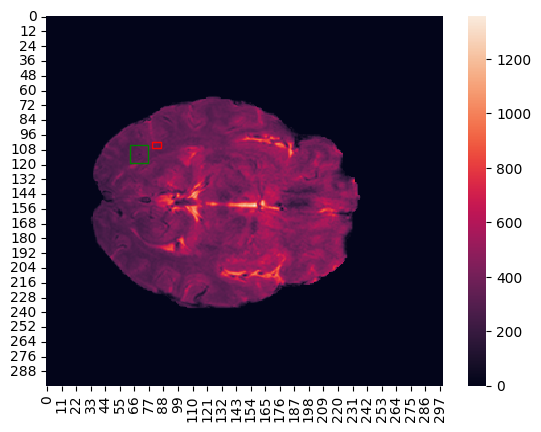

In [27]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(x[target].squeeze().cpu())

truth = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (y[0], y[1]),
    y[2] - y[0],
    y[3] - y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()